In [1]:
import keras
from keras import models, layers
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
from scipy.ndimage import imread
from scipy.misc import imresize
from nbutil import imshow_multi
from PIL import Image
import random

Using TensorFlow backend.


In [2]:
def to_pil(img):
    if img.shape[-1] == 1:
        img = img[:,:,0] # these are grayscale
    return Image.fromarray(np.clip(img * 255, 0, 255).astype(np.uint8))

In [3]:
data_dir = '/Users/nateparrott/Documents/School/cv/proj6/data/15SceneData'
categories = [c for c in os.listdir(os.path.join(data_dir, 'train')) if c[0] != '.']

SIZE = 64

def load_dataset(name):
    images = []
    labels = []
    for cat in categories:
        for filename in os.listdir(os.path.join(data_dir, name, cat)):
            if filename.endswith('.jpg'): 
                path = os.path.join(data_dir, name, cat, filename)
                image = imread(path)
                h,w = image.shape[:2]
                # top-left crop
                if h > w:
                    image = image[:w, :]
                else:
                    image = image[:, :h]
                image = imresize(image, size=[SIZE, SIZE], mode='L')
                images.append(image)
                labels.append(categories.index(cat))
    images = np.expand_dims(np.stack(images) / 255.0, -1)
    labels = np.expand_dims(np.stack(labels).astype(int), -1)
    return images, labels

trainx, trainy = load_dataset('train')
testx, testy = load_dataset('test')


In [4]:
image_gen = ImageDataGenerator(rotation_range=5, 
                               zoom_range=0.2, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               horizontal_flip=True,
                               channel_shift_range=0.1)


(64, 64, 1)


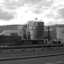

In [5]:
print trainx[0].shape
to_pil(random.choice(trainx))

In [ ]:
input = layers.Input(shape=(SIZE, SIZE, 1))
x = input
y_dim = len(categories)

def layer(x, out_channels):
    _, h, w, in_channels = x.shape
    
    x1 = layers.Conv2D(out_channels / 2, (1, 1), padding='SAME', activation='relu')(x)
    
    x2 = x
    for i, ksize in enumerate([1, 3, 3]):
        x2 = layers.Conv2D(out_channels / 2, (ksize, ksize), padding='SAME', activation='relu')(x)
    
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    return x

n_layers = 5
for i in xrange(n_layers):
    chans = min(128, 16 ** 2**i)
    x = layer(x, chans)
    
    _, h, w, channels = x.shape
    pool_size = h.value if i == n_layers-1 else 2
    x = layers.pooling.AveragePooling2D(pool_size=(pool_size, pool_size), strides=(2, 2))(x)
    print x.get_shape()

x = layers.Flatten()(x)
x = layers.Dense(y_dim * 4, activation='relu')(x)
print x.get_shape()
x = layers.Dense(y_dim, activation='softmax')(x)
print x.get_shape()
model = models.Model(inputs=[input], outputs=[x])

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
model.summary()

(?, 32, 32, 16)
(?, 16, 16, 128)
(?, 8, 8, 128)
(?, 4, 4, 128)
(?, 1, 1, 128)
(?, 60)
(?, 15)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 64, 8)     16                                           
____________________________________________________________________________________________________
conv2d_4 (Conv2D)                (None, 64, 64, 8)     80                                           
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 64, 64, 16)    0                                          

In [ ]:
batch_size = 32

for i in xrange(40):
    model.fit_generator(image_gen.flow(trainx, trainy, batch_size=batch_size),
                       steps_per_epoch=len(trainx)/batch_size,
                       verbose=1,
                       epochs=1)
    if i % 1 == 0:
        score = model.evaluate(testx, testy, verbose=0)
        print 'epoch: {}, accuracy: {}'.format(i+1, score[1])

Epoch 1/1
46/46 [==============================] - 59s - loss: 2.7024 - acc: 0.0904      

In [ ]:
score = model.evaluate(testx, testy, verbose=0)
print 'accuracy: {}'.format(score[1])